In [1]:
import nest
import numpy as np
import matplotlib.pyplot as plt
from tools.helper import filter_spikes, filter_spikes_parallel, compute_capacity
from sklearn.decomposition import PCA



              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.8.0
 Built: Jun 13 2025 00:07:12

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
dt = 0.1 # ms (simulation resolution)
num_threads = 16 # Number of CPU threads to use for parallel computation

We start with a very simple experiment: driving a single layer of unconnected neurons with a piecewise constant input signals, representing sensory stimulation whose magnitude changes over time. This can be seen, for example, as an abstraction of a simple visual psychophysics experiment where the amplitude corresponds to the brightness of a visual stimulus presented on a screen and subjects are asked to report if they can see the stimulus. 

## Stimulus generation

The first step is to generate the stimulus. We will generate a piecewise constant signal with random amplitudes in the range [0, 1] to be presented sequentially to a population of neurons.


In [ ]:
# Stimulus parameters
nValues = 5      # Number of brightness values
nTrials = 20     # Determine the number of trials (unique presentations of each brightness value)
stimulus_duration = 100. # Duration of each stimulus presentation (in ms)
dt = 0.1         # resolution (in ms)

In [4]:
# Create inputs
brightness = np.linspace(0, 100, nValues)

# Create a random stimulus order from 1 to nTrials*nValues
stimulus_order = np.random.permutation(nTrials*nValues)

# Create a range from 0-9 with 20 instances each (easier using modulus)
stimulus_order = stimulus_order % nValues

##
x = np.array([(brightness[n]/100.)+.1 for n in stimulus_order])
times = np.arange(dt, (nTrials*nValues*stimulus_duration), stimulus_duration)

![stimulus_visualization](plots/stimulus_visualization.png)



## Stimulus Encoding
Let's create an appropriate encoding scheme, where the time-varying input signal $x(t)$ is mapped to input currents $I(t)$ that drive a population of neurons, as illustrated below. The first aspect to consider are the so-called tuning curves, or receptive fields, of the neurons. Each neuron in the brain circuits that receive sensory inputs responds preferentially to a specific input range. 

![NEF.png](plots/NEF.png)

The continuous input signal $x(t)$ is converted to an input current $I_{in}(t)$ delivered to a population of spiking neurons. We randomize the tuning of this population, so that each neuron receives a slightly different "version" of the input signal, i.e.:

\begin{equation}
I(t) = <\mathbf{x}(t)^{T} . \mathbf{e} > + \mathbf{\beta} 
\end{equation}

where $\mathbf{e}$ specifies the tuning and $\mathbf{\beta}$ is a fixed bias current. 

In [5]:
# Network and simulation parameters
N = 100         # Number of neurons
SimT = nTrials*nValues*stimulus_duration # Total simulation time

In [6]:
# Tuning curves for encoding layer
tuning = 250. * np.random.randn(N) + 1000.
amplitudes = np.zeros((N, len(x)))

In [8]:
# Prepare simulation
nest.ResetKernel()
nest.SetKernelStatus({'resolution': dt,
                      'print_time': True,
                    #   'local_num_threads': num_threads, 
                      'total_num_virtual_procs': num_threads})


Sep 04 23:12:52 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.


In [9]:
# Create the encoding current generators
step_generator = nest.Create('step_current_generator', N)

## Neural Population
Now, let's create a single layer of LIF neurons. This is the simplest spiking neuron model, with linear sub-threshold dynamics and a simple spike triggering and reset mechanism (threshold crossing and clamping):

![LIF.png](plots/LIF.png)

To improve the quality of the encoding and ensure variability in population responses (which is important for information representation, to reduce redundancy), we will add some variability in the neuronal population by drawing some critical parameters, like firing thresholds, from a uniform distribution.

In [ ]:
J_bias = 200.0  # [pA] - constant bias current

# randomize thresholds and initial states
thresholds = 5 * np.random.randn(N) - 50.
Vm0 = np.array(np.random.uniform(low=-70., high=-50., size=int(N)))

pop = nest.Create('iaf_psc_alpha', N, {'I_e': J_bias})

Now we create the input current generator and set the stimulus tuning and neuron parameters

In [11]:
for n in range(N):
	amplitudes[n, :] = x * tuning[n]
	pop[n].set({'V_m': Vm0[n], 'V_th': thresholds[n]})
	step_generator[n].set({'amplitude_times': times,
                          'amplitude_values': amplitudes[n]})

	nest.Connect(step_generator[n], pop[n])

Setup the recording devices (for now, we'll only record spikes, but later we can try to explore reading the $V_{m}$ directly)

In [12]:
spk_det = nest.Create('spike_recorder')
nest.Connect(pop, spk_det)

## Simulate

Now, we have our network set up, we can simulate it. 

In [ ]:
print(f"Starting simulation for {SimT} ms...")

nest.Simulate(SimT)

## Process population activity

The next step is to extract the recorded population activity and see how it looks like.

In [15]:
spike_times = nest.GetStatus(spk_det)[0]['events']['times']
neuron_ids = nest.GetStatus(spk_det)[0]['events']['senders']

time_vector = np.arange(0., SimT, dt)
signal = np.zeros_like(time_vector)
for tt in range(len(times)-1):
	signal[int(times[tt]/dt):int(times[tt+1]/dt)] = x[tt]

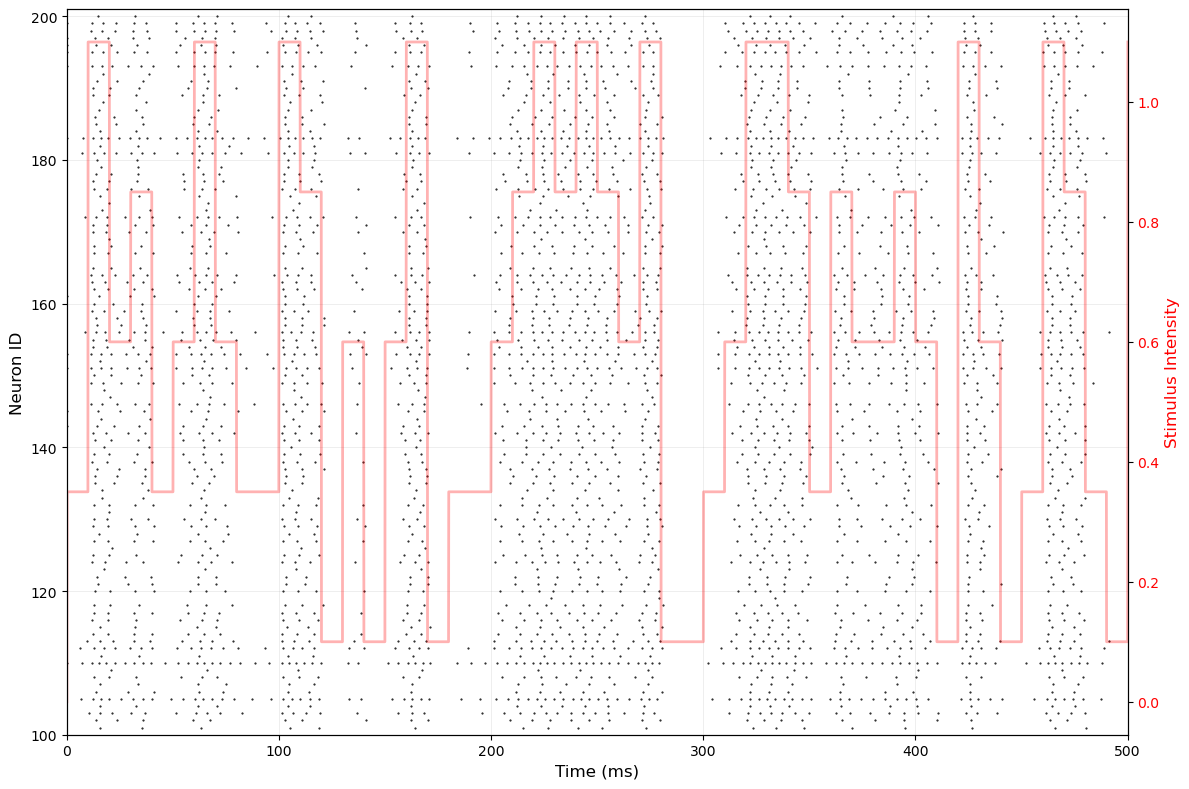

In [16]:
## Plot
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
# Plot raster (spike times vs neuron IDs)
ax.plot(spike_times, neuron_ids, '.k', markersize=1, alpha=1, label='Spikes')

# Set primary y-axis for neuron IDs
ax.set_ylabel('Neuron ID', fontsize=12, color='black')
ax.tick_params(axis='y', labelcolor='black')
ax.set_ylim(np.min(neuron_ids) - 1, np.max(neuron_ids) + 1)

ax2 = ax.twinx()
ax2.plot(time_vector, signal, 'r-', linewidth=2, alpha=0.3, label='Stimulus Signal')
ax2.set_ylabel('Stimulus Intensity', fontsize=12, color='red')
ax2.tick_params(axis='y', labelcolor='red')

ax.set_xlim(0, 500)
ax2.set_xlim(0, 500)
ax.set_xlabel('Time (ms)', fontsize=12)
    
# Add grid for better readability
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    
# Tight layout
plt.tight_layout()

The neural activity needs to be further processed as the decoders require a continuous signal. The common practice is to convolve the spiking activity with an exponential kernel, to mimic the integration performed by the postsynaptic membrane upon an incoming spike. An alternative would be to directly readout the membrane voltages (see e.g. [this paper](https://2017.ccneuro.org/abstracts/abstract_3000204.pdf)).

$a_{i}(t) = s_{i}(t) * \exp(-t/\tau)$

In [17]:
filter_tau = 20. # [ms]

activity = nest.GetStatus(spk_det)[0]['events']
# states = filter_spikes(activity['times'], activity['senders'], NE, t_start=0., t_stop=num_steps*step_duration, dt=dt, tau=filter_tau)

# if you can use parallelization, it can be very useful here:
states = filter_spikes_parallel(activity['times'], activity['senders'], N, t_start=0., t_stop=SimT, dt=dt, tau=filter_tau, n_processes=num_threads)

Filtering SpikeTrains: 100%|██████████| 100/100 [00:06<00:00, 15.57it/s]


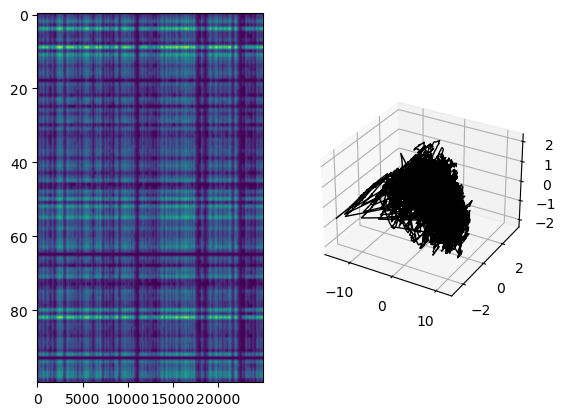

In [18]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.imshow(states, aspect='auto')
ax2 = fig.add_subplot(122, projection='3d')
pca_fit = PCA(n_components=np.shape(states)[0])
X = pca_fit.fit_transform(states.T)
ax2.plot(X[:, 0], X[:, 1], X[:, 2], color='k', lw=1)

## Decoding
If the input-driven dynamics contains enough information, we should be able to reconstruct some target signal. For this purpose, we will use standard linear regression as described below. If the state of the circuit is stored in a matrix $X$ and the target signal to reconstruct is $y$, we can estimate the optimal linear projection as:
\begin{equation}
D = \left( X^{T}X\right)^{-1} X^{T}Y
\end{equation}

In the simplest case that we explore in this example, we want to reconstruct the original input signal, i.e. $y(t)=u(t)$. 

In [19]:
Gamma = np.zeros((N, N))
Ups = np.zeros(N)
for i in range(N):
	for j in range(N):
		Gamma[i,j] = np.dot(states[i,:], np.transpose(states[j,:]))
		Ups[j] = np.dot(states[j,:], signal)

decoder = np.dot(np.linalg.pinv(Gamma), Ups)
decoded_x = np.dot(states.transpose(), decoder)

In [ ]:
# Note that this is similar to
# reg = LinearRegression(n_jobs=-1, fit_intercept=False, copy_X=False).fit(states.T, signal)
# decoded_x = reg.predict(states.T)

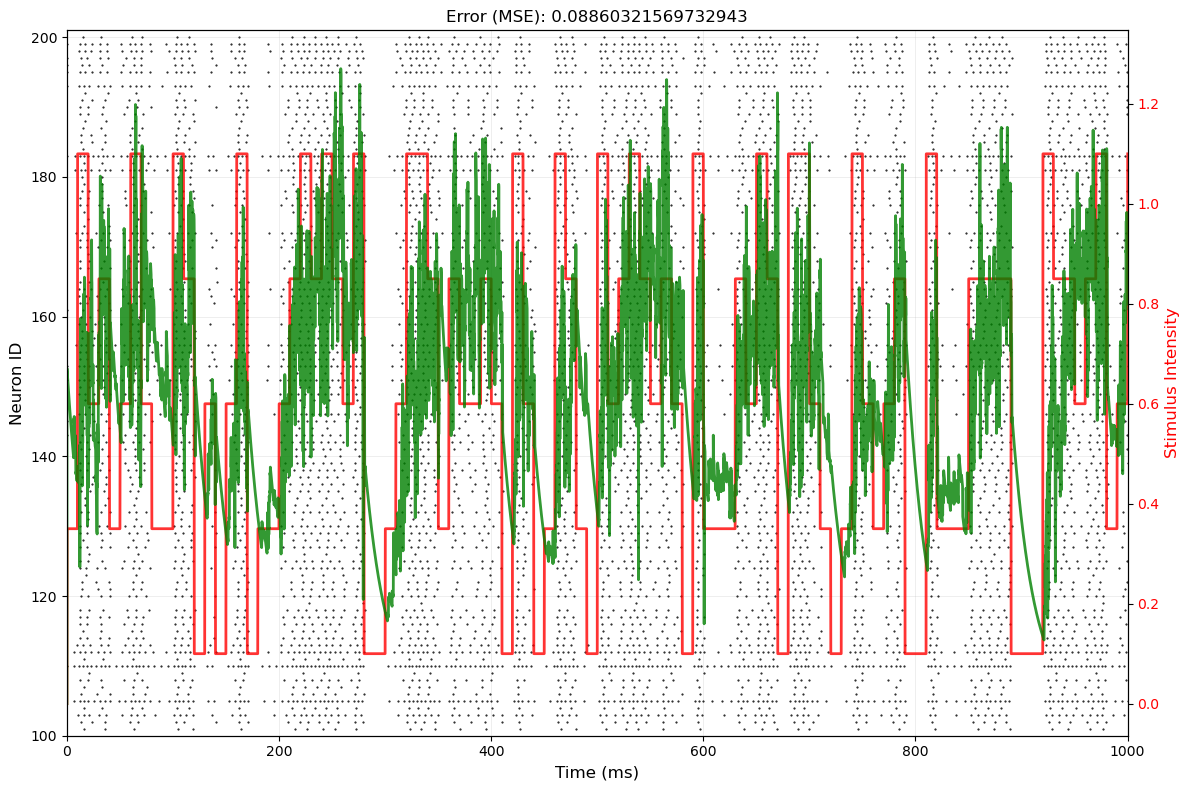

In [20]:
## Plot
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
# Plot raster (spike times vs neuron IDs)
ax.plot(spike_times, neuron_ids, '.k', markersize=1, alpha=1, label='Spikes')

# Set primary y-axis for neuron IDs
ax.set_ylabel('Neuron ID', fontsize=12, color='black')
ax.tick_params(axis='y', labelcolor='black')
ax.set_ylim(np.min(neuron_ids) - 1, np.max(neuron_ids) + 1)

ax2 = ax.twinx()
ax2.plot(time_vector, signal, 'r-', linewidth=2, alpha=0.8, label='Stimulus Signal')
ax2.plot(time_vector, decoded_x, 'g-', linewidth=2, alpha=0.8, label='Decoded Signal')
ax2.set_ylabel('Stimulus Intensity', fontsize=12, color='red')
ax2.tick_params(axis='y', labelcolor='red')

ax.set_xlim(0, 1000)
ax2.set_xlim(0, 1000)
ax.set_xlabel('Time (ms)', fontsize=12)
ax.set_title('Error (MSE): ' + str(np.mean((signal-decoded_x)**2)))
    
# Add grid for better readability
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    
# Tight layout
plt.tight_layout()

MSE: 0.08744677943821748
Capacity: 0.3029030808907117
Lag: 1

Elapsed time: 0.26141786575317383 s
MSE: 0.08644089035184252
Capacity: 0.3109273729844077
Lag: 2

Elapsed time: 0.34888315200805664 s
MSE: 0.08547103643813189
Capacity: 0.31858584577284166
Lag: 3

Elapsed time: 0.18082332611083984 s
MSE: 0.0844528407223106
Capacity: 0.32664522497401605
Lag: 4

Elapsed time: 0.22438406944274902 s
MSE: 0.08345526058819897
Capacity: 0.33455494014304965
Lag: 5

Elapsed time: 0.15093183517456055 s
MSE: 0.08246042096722303
Capacity: 0.3424567032125429
Lag: 6

Elapsed time: 0.46480226516723633 s
MSE: 0.08142746523551989
Capacity: 0.35067419556380786
Lag: 7

Elapsed time: 0.5693295001983643 s
MSE: 0.08044294739903109
Capacity: 0.35851942317051627
Lag: 8

Elapsed time: 0.7395074367523193 s
MSE: 0.07941398795119374
Capacity: 0.36673277970464074
Lag: 9

Elapsed time: 0.7032592296600342 s
MSE: 0.078402136733296
Capacity: 0.3748108769495205


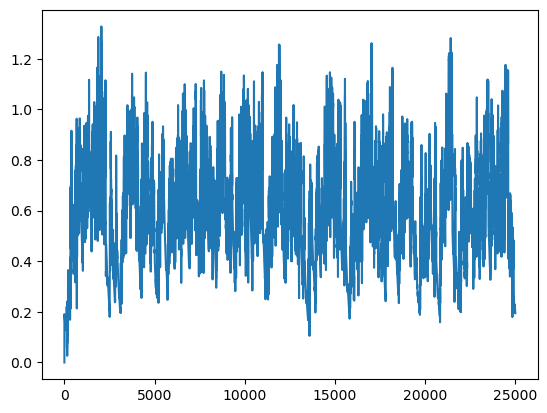

In [ ]:
plt.plot(decoded_x)

print('MSE:', np.mean((signal-decoded_x)**2))
capacity = 1. - (np.mean((signal - decoded_x) ** 2) / np.var(signal))
print("Capacity: {0}".format(str(capacity)))

# memory curve
capacities = []
for time_lag in np.arange(1, 10, 1):
	print("Lag: {0}".format(time_lag))
	_, c, error, norm = compute_capacity(states[:, time_lag:], signal[:-time_lag])
	print('MSE:', error)
	print("Capacity: {0}".format(str(c)))
	capacities.append(c)

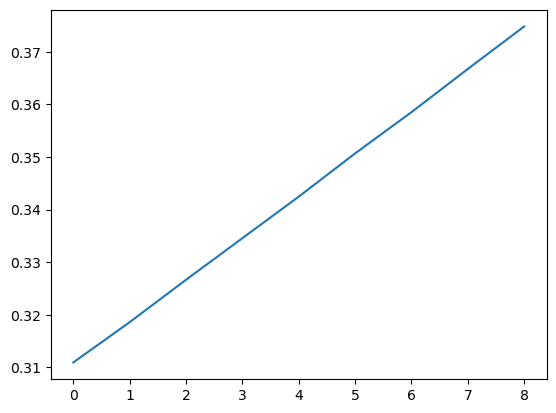

In [ ]:
plt.plot(capacities)